# Wild Blueberry Yield Prediction

"The dataset used for predictive modeling was generated by the Wild Blueberry Pollination Simulation Model, which is an open-source, spatially-explicit computer simulation program that enables exploration of how various factors, including plant spatial arrangement, outcrossing and self-pollination, bee species compositions and weather conditions, in isolation and combination, affect pollination efficiency and yield of the wild blueberry agroecosystem. The simulation model has been validated by the field observation and experimental data collected in Maine USA and Canadian Maritimes during the last 30 years and now is a useful tool for hypothesis testing and theory development for wild blueberry pollination researches."

The aim it to predict blueberry yield

Features Unit Description:
- Clonesize m2 The average blueberry clone size in the field
- Honeybee bees/m2/min Honeybee density in the field
- Bumbles bees/m2/min Bumblebee density in the field
- Andrena bees/m2/min Andrena bee density in the field
- Osmia bees/m2/min Osmia bee density in the field
- MaxOfUpperTRange ℃ The highest record of the upper band daily air temperature during the bloom season
- MinOfUpperTRange ℃ The lowest record of the upper band daily air temperature
- AverageOfUpperTRange ℃ The average of the upper band daily air temperature
- MaxOfLowerTRange ℃ The highest record of the lower band daily air temperature
- MinOfLowerTRange ℃ The lowest record of the lower band daily air temperature
- AverageOfLowerTRange ℃ The average of the lower band daily air temperature
- RainingDays Day The total number of days during the bloom season, each of which has precipitation larger than zero
- AverageRainingDays Day The average of raining days of the entire bloom season
- 'fruitset', 'fruitmass', 'seeds' **non** defined

Resources:
- [Kaggle challenge](https://www.kaggle.com/competitions/playground-series-s3e14/overview)

In [2]:
# importing standard libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve, LearningCurveDisplay, ShuffleSplit

from xgboost import XGBRegressor

import lightgbm as lgb

In [26]:
# Define Seaborn theme parameters
theme_parameters =  {
    'axes.spines.right': False,
    'axes.spines.top': False,
    'grid.alpha':0.3,
    'axes.titlesize': 16,
    'figure.figsize': (12, 4),
}

# Set the theme
sns.set_theme(style='whitegrid',
              palette=sns.color_palette('colorblind'), 
              rc=theme_parameters)

# Read Data

In [1]:
read_from_kaggle = False

In [14]:
if read_from_kaggle:
    
    df_train = pd.read_csv("/kaggle/input/playground-series-s3e14/train.csv")
    df_test = pd.read_csv("/kaggle/input/playground-series-s3e14/test.csv")
    
else:

    df_train = pd.read_csv("./../data/blueberry_train.csv")
    df_test = pd.read_csv("./../data/blueberry_test.csv")

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15289 entries, 0 to 15288
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    15289 non-null  int64  
 1   clonesize             15289 non-null  float64
 2   honeybee              15289 non-null  float64
 3   bumbles               15289 non-null  float64
 4   andrena               15289 non-null  float64
 5   osmia                 15289 non-null  float64
 6   MaxOfUpperTRange      15289 non-null  float64
 7   MinOfUpperTRange      15289 non-null  float64
 8   AverageOfUpperTRange  15289 non-null  float64
 9   MaxOfLowerTRange      15289 non-null  float64
 10  MinOfLowerTRange      15289 non-null  float64
 11  AverageOfLowerTRange  15289 non-null  float64
 12  RainingDays           15289 non-null  float64
 13  AverageRainingDays    15289 non-null  float64
 14  fruitset              15289 non-null  float64
 15  fruitmass          

In [65]:
df_train.head()

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,0,25.0,0.50,0.25,0.75,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.425011,0.417545,32.460887,4476.81146
1,1,25.0,0.50,0.25,0.50,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.444908,0.422051,33.858317,5548.12201
2,2,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.552927,0.470853,38.341781,6869.77760
3,3,12.5,0.25,0.25,0.63,0.50,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.565976,0.478137,39.467561,6880.77590
4,4,25.0,0.50,0.25,0.63,0.63,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.579677,0.494165,40.484512,7479.93417


In [8]:
df_train.describe()

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
count,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000
mean,7644.000000,19.704690,0.389314,0.286768,0.492675,0.592355,82.169887,49.673281,68.656256,59.229538,28.660553,48.568500,18.660865,0.324176,0.502741,0.446553,36.164950,6025.193999
std,4413.698468,6.595211,0.361643,0.059917,0.148115,0.139489,9.146703,5.546405,7.641807,6.610640,3.195367,5.390545,11.657582,0.163905,0.074390,0.037035,4.031087,1337.056850
min,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,69.700000,39.000000,58.200000,50.200000,24.300000,41.200000,1.000000,0.060000,0.192732,0.311921,22.079199,1945.530610
25%,3822.000000,12.500000,0.250000,0.250000,0.380000,0.500000,77.400000,46.800000,64.700000,55.800000,27.000000,45.800000,16.000000,0.260000,0.458246,0.419216,33.232449,5128.163510
50%,7644.000000,25.000000,0.500000,0.250000,0.500000,0.630000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,16.000000,0.260000,0.506600,0.446570,36.040675,6117.475900
75%,11466.000000,25.000000,0.500000,0.380000,0.630000,0.750000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,24.000000,0.390000,0.560445,0.474134,39.158238,7019.694380
max,15288.000000,40.000000,18.430000,0.585000,0.750000,0.750000,94.600000,57.200000,79.000000,68.200000,33.000000,55.900000,34.000000,0.560000,0.652144,0.535660,46.585105,8969.401840


In [9]:
# drop id column
df_train = df_train.drop(columns='id', axis=1)

# Exploratory Data Analysis - EDA

## Features distribution train vs validation set KDEs

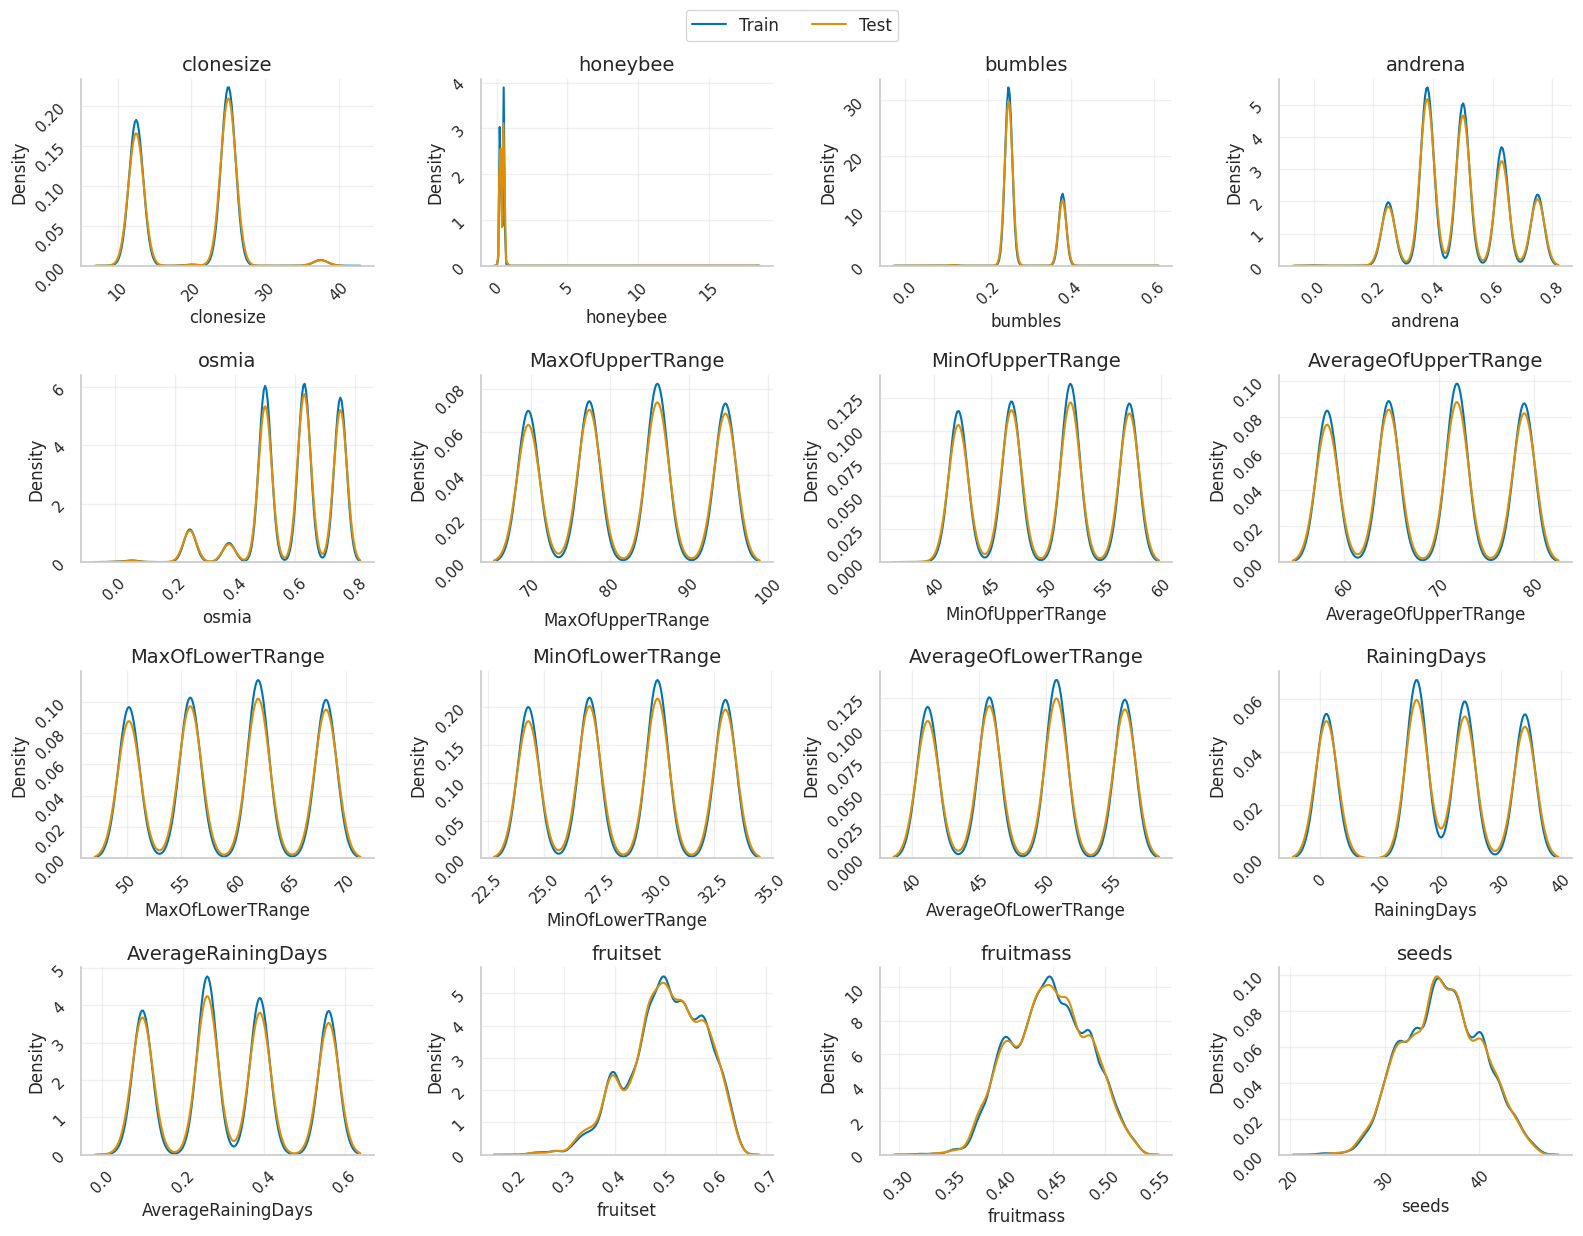

In [10]:
figure, ax = plt.subplots(4, 4, figsize=(16, 12))
ax = ax.flatten()

for index, col_name in enumerate(df_train.columns[:-1]):
    
    sns.kdeplot(data=df_train[col_name],
                label='Train',
                ax=ax[index])
    
    sns.kdeplot(data=df_test[col_name],
                label='Test',
                ax=ax[index])
   
    ax[index].set_title(col_name, fontsize=14)
    
    ax[index].tick_params(labelrotation=45)
    
    # Retrieve legend information
    handles = ax[index].get_legend_handles_labels()[0]
    labels = ax[index].get_legend_handles_labels()[1]
    ax[index].legend().remove()

# Set the legend
figure.legend(handles, 
              labels, 
              loc='upper center', 
              bbox_to_anchor=(0.5, 1.03), 
              fontsize=12,
              ncol=3)

plt.tight_layout()

- The distribution of the features is consistend between train and validation sets

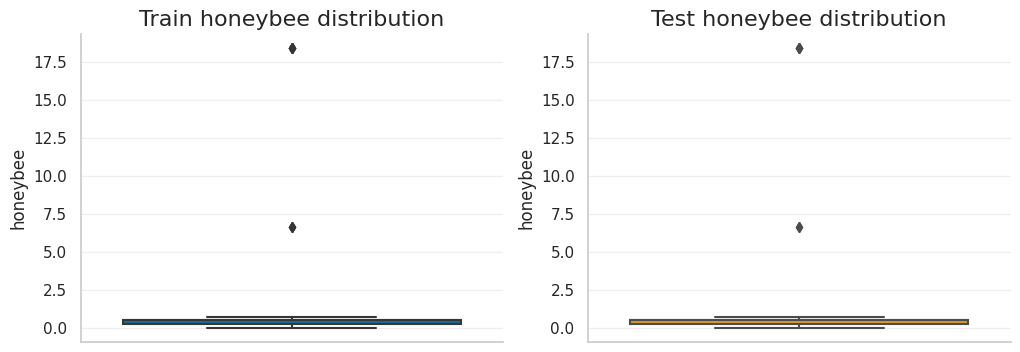

In [11]:
figure, ax = plt.subplots(1, 2)
ax = ax.flatten()

sns.boxplot(data=df_train, 
            y='honeybee',
            ax=ax[0])

sns.boxplot(data=df_test,
            y='honeybee',
            ax=ax[1],
            color='orange')

ax[0].set_title('Train honeybee distribution')

ax[1].set_title('Test honeybee distribution')

plt.show()

In [12]:
df_train['honeybee'].value_counts().sort_index(ascending=False).head(5)

18.430       5
6.640        3
0.750      110
0.537       38
0.500     7832
Name: honeybee, dtype: int64

- Outlyers of honeybees need to be dropped before modeling (just on df_train)

In [13]:
# dropping 'honeybee' values >= 5 in test
# df_train = df_train[df_train['honeybee'] < 5].reset_index()

## Label distribution KDE

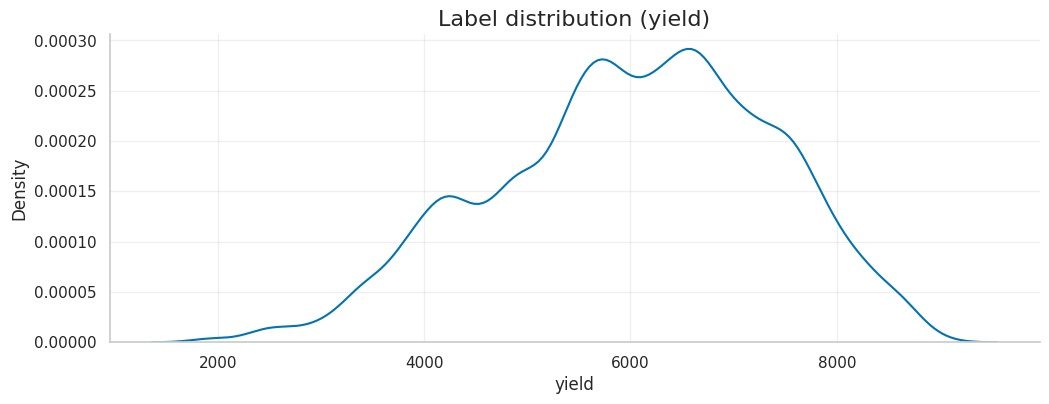

In [14]:
sns.kdeplot(data=df_train['yield'],
            label='Train')

plt.title('Label distribution (yield)')

plt.show()

The distribution of the label yield looks similar to the distribution of the features 'fruitset', 'fruitmass' and 'seeds'. Since these features are not described (see notebook intro) we can hypotesize that they have been inferred from the label yield.

## Pearson Correlation

In [15]:
# Generate correlation matrix
correlation_train = df_train.corr(method='pearson')

In [16]:
# Generate a mask for the upper triangle
correlation_mask = np.triu(np.ones_like(correlation_train, dtype=bool))

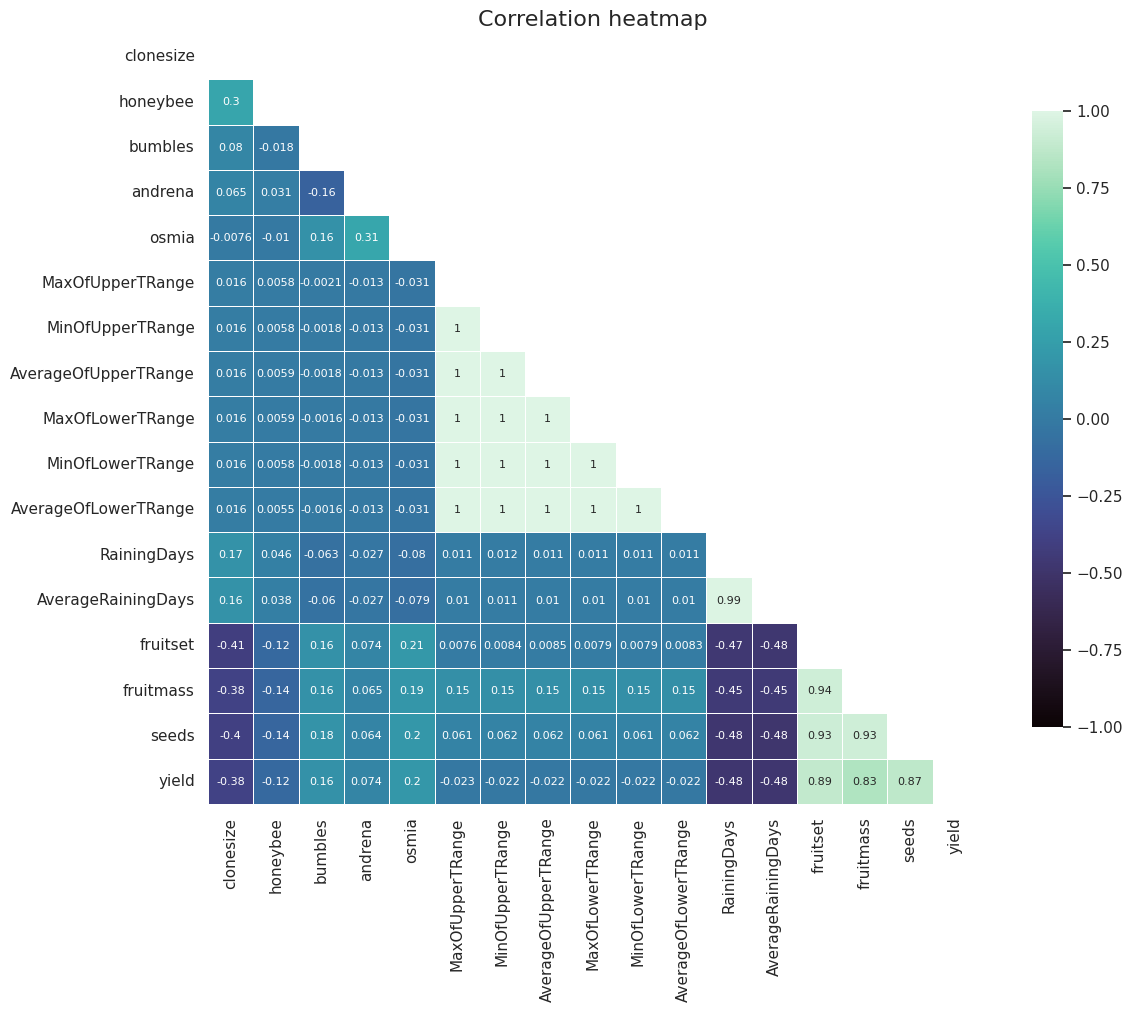

In [17]:
figure, ax = plt.subplots(figsize=(14, 10))

ax = sns.heatmap(correlation_train, 
            mask=correlation_mask, 
            cmap='mako',
            vmax=1.0, 
            vmin=-1.0, 
            center=0, 
            square=True, 
            linewidths=.5, 
            annot=True,
            annot_kws={'fontsize': 8},
            cbar_kws={"shrink":.8, 'orientation':'vertical'})


ax.set_title('Correlation heatmap')

plt.show()

- The correlation matrix shows a very similar and a high correlation behaviour between the features 'fruitset', 'fruitmass' and 'seeds and the lable 'yield', thus the above hypotesis was quite likely correct
- The feature 'clonesize' and 'honeybee' looks to be positively correlated (0.85), we can hypotesize that honeybees are attracted to blueberry cultivation with higher clonesize (maybe because the domestication of honeybees). Anyway, this doesn't appear to translate into a highet yield
- The temperature measures are duplicated, it's enough to keep just one
- Same with AverageRainingDays and RainingDays. Dropping AverageRainingDays

 ## Pairplot
 
 Plotting pairplots between main features to look at potential non-linear relaationships

In [18]:
df_train.columns

Index(['clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia',
       'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange',
       'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange',
       'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds',
       'yield'],
      dtype='object')

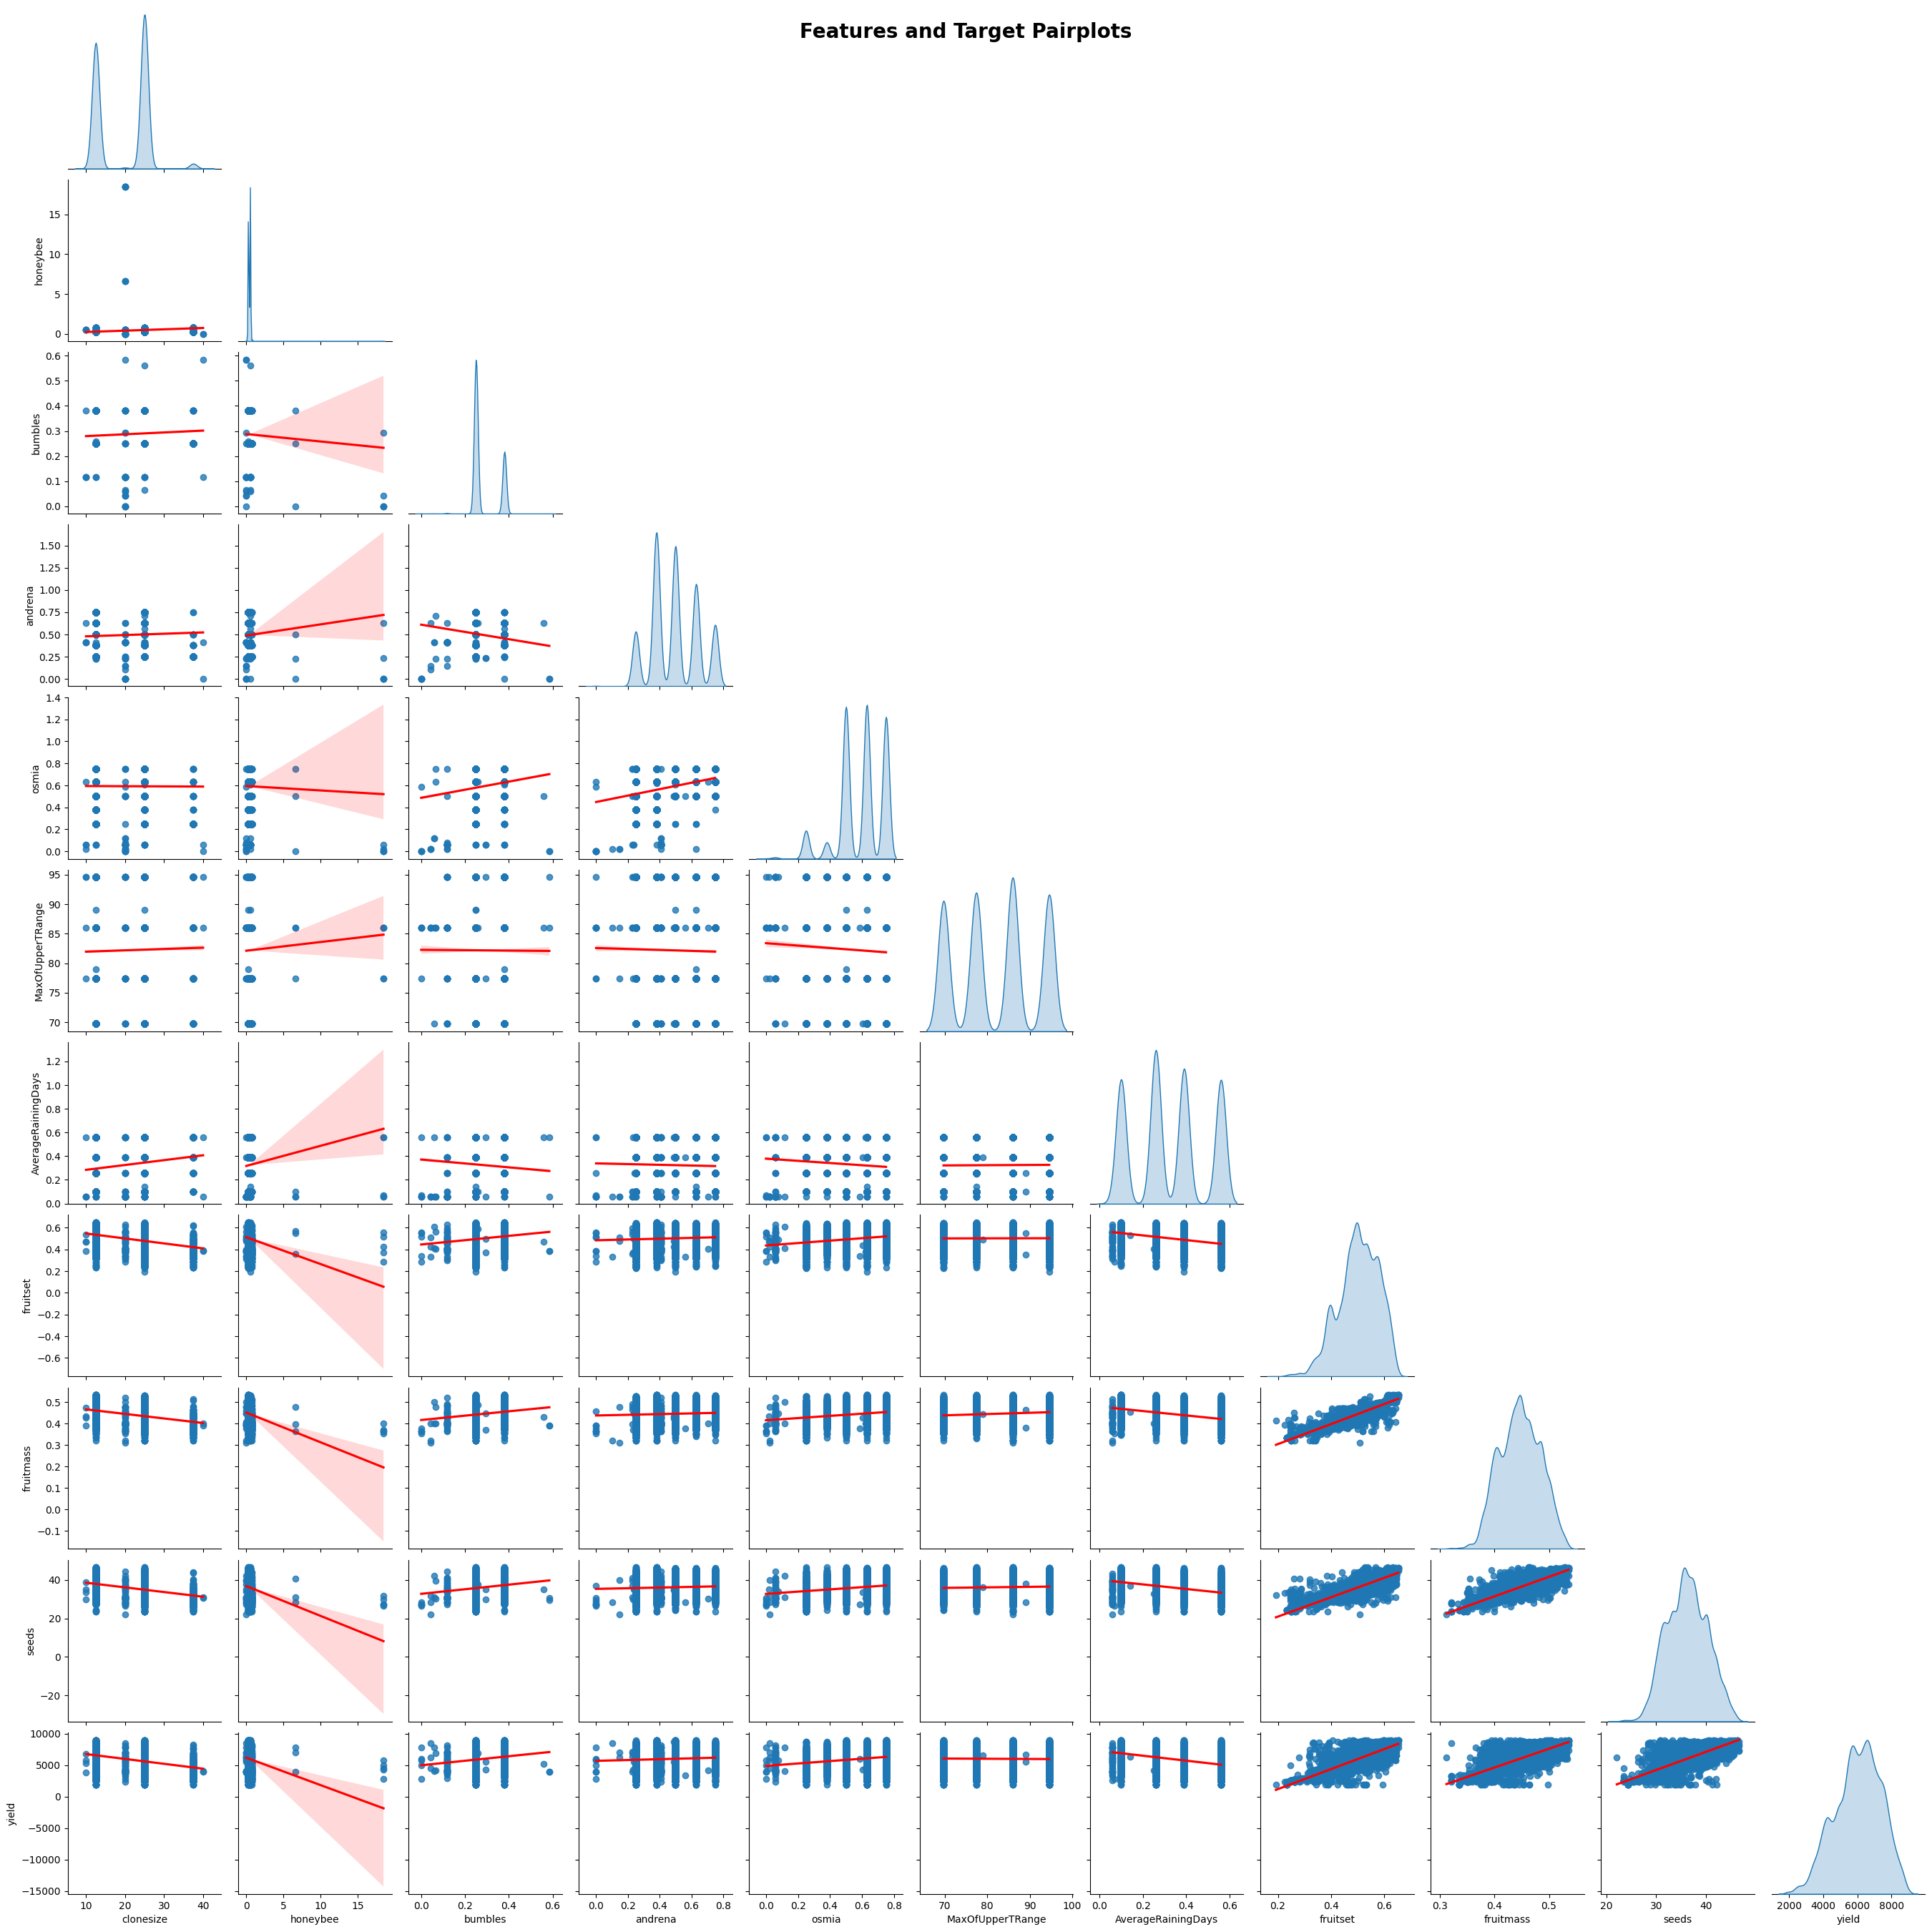

In [26]:
sns.pairplot(df_train[['clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia', 'MaxOfUpperTRange', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds', 'yield']],
             kind="reg",
             diag_kind='kde',
             plot_kws={'line_kws':{'color':'red'}},
             corner=True)

plt.suptitle('Features and Target Pairplots', 
             fontsize=20, 
             fontweight='bold')

plt.show()

The data are probably AI generated. Doesn't look like there are particular non-linar relationships between features.

# Preprocessing data before modeling

## Get the datasets model-ready

In [27]:
def compute_engineered_features(data: pd.DataFrame) -> pd.DataFrame:
    
    """
    Create engineered features to have the dataset model-ready
    
    Args:
        data Pandas.DataFrame input
    
    Returns:
        data Pandas.DataFrame with engineered features
    """
    
    # Create a feature clonesize per honeybee
    data['clonesize per honeybee'] = data['clonesize'] * data['honeybee']
    
    return data

In [28]:
# get the train data model-ready
df_train = compute_engineered_features(df_train.copy())

# get the test data model-ready
df_test = compute_engineered_features(df_test.copy())

## Defining features and label

In [29]:
features = ['clonesize', 
            'honeybee', 
            'bumbles', 
            'andrena', 
            'osmia', 
            'AverageOfUpperTRange',
            'AverageRainingDays', 
            'fruitset', 
            'fruitmass', 
            'seeds',
            'clonesize per honeybee']

label = ['yield']

## Scaling data

In [30]:
# Scaling train data with StandardScaler
scaler = StandardScaler(copy=True,
                        with_mean=True,
                        with_std=True)

scaler.fit(df_train[features])

df_train_scaled = pd.DataFrame(scaler.transform(df_train[features]))

# Scaling removed column names - put them back
df_train_scaled.columns = features

In [31]:
# Scaling test data
df_test_scaled = pd.DataFrame(scaler.transform(df_test[features]))

# Scaling removed column names - put them back
df_test_scaled.columns = features

## Splitting data between train and test set

In [32]:
# defining a seed
seed = 108

In [33]:
# Define X and y for the training set
X = df_train_scaled
y = df_train.iloc[:, -2]

# Splitting train dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

# Model Training

In [34]:
# Define metric(s) to compare the models
metrics = ['RMSE']

# Initialize DataFrame of model performance
performance = pd.DataFrame(columns=metrics)

## Linear Regression

In [35]:
%%time

# Instantiate a LinearRegression model
model_lr = LinearRegression()

# Fit logreg to the train set
model_lr.fit(X_train, y_train)

# predict y_pred values
y_pred_lr = model_lr.predict(X_test)

# Compute RMSE metric
rmse_lr = round(mean_squared_error(y_test, y_pred_lr) ** 0.5, 2)

print('RMSE: {}'.format(rmse_lr))

RMSE: 568.66
CPU times: total: 31.2 ms
Wall time: 42 ms


In [36]:
# Update 'performance' DataFrame
performance.loc['Linear Regression'] = [rmse_lr]

## Random Forest Regressor

In [38]:
%%time

# Instantiate rf
model_rf = RandomForestRegressor(n_estimators=25,
                                 random_state=seed)
            
# Fit rf to the training set    
model_rf.fit(X_train, y_train) 

# Predict the test set labels
y_pred_rf = model_rf.predict(X_test)

# Evaluate the test set RMSE
rmse_rf = round(mean_squared_error(y_test, y_pred_rf) ** 0.5, 2)

# Print rmse_test
print('RMSE: {}'.format(rmse_rf))

RMSE: 579.59
CPU times: total: 1.62 s
Wall time: 1.63 s


In [48]:
# Update 'performance' DataFrame
performance.loc['Random Forest Regressor'] = [rmse_rf]

## Gradient Boosting Regressor

In [39]:
%%time

# Instantiate gb
model_gb = GradientBoostingRegressor(max_depth=4, 
                                     n_estimators=200,
                                     random_state=2)

# Fit gb to the training set
model_gb.fit(X_train, y_train)

# Predict test set labels
y_pred_gb = model_gb.predict(X_test)

# Evaluate the test set RMSE
rmse_gb = round(mean_squared_error(y_test, y_pred_gb) ** 0.5, 2)

# Print rmse_test
print('RMSE: {}'.format(rmse_gb))

RMSE: 549.01
CPU times: total: 3.08 s
Wall time: 3.08 s


In [40]:
# Update 'performance' DataFrame
performance.loc['Gradient Boosting Regressor'] = [rmse_gb]

## XGBoost Regressor

In [41]:
# define XGBoost hyperparams dict
hyperparams_xgb = {
    'n_estimators' : 500,
    'max_depth' : 5,
    'learning_rate' : 0.01
}

In [42]:
# Define the model
model_xgb = XGBRegressor(**hyperparams_xgb)

# Train the xgb to the training set
model_xgb.fit(X_train, y_train)

# Get predictions
y_pred_xgb = model_xgb.predict(X_test)

# Compute metrics
rmse_xgb = round(mean_squared_error(y_test, y_pred_xgb) ** 0.5, 2)

print('RMSE: {}'.format(rmse_xgb))

RMSE: 549.11


In [43]:
# Update 'performance' DataFrame
performance.loc['XGBoost Regressor'] = [rmse_xgb]

## LightGBM

In [44]:
# define LightGBM hyperparams dict
hyperparams_lgb = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'force_row_wise': True,
    'n_estimators': 1000,
    'verbose': 0
}

In [45]:
%%time

# Define the model
model_lgb = lgb.LGBMRegressor(**hyperparams_lgb)

# Fit model to the training set
model_lgb.fit(X_train, np.ravel(y_train))

# Get predictions
y_pred_lgb = model_lgb.predict(X_test)

# Compute metrics
rmse_lgb = round(mean_squared_error(y_test, y_pred_lgb) ** 0.5, 2)

print('RMSE: {}'.format(rmse_lgb))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
RMSE: 592.76
CPU times: total: 8.39 s
Wall time: 1.15 s


In [46]:
# Update 'performance' DataFrame
performance.loc['LightGBM Regressor'] = [rmse_lgb]

# Model comparison

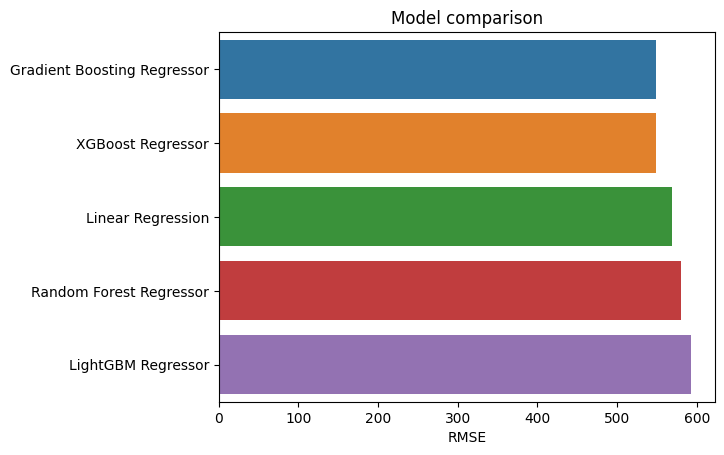

In [49]:
# Sort dataframe by the metric
performance.sort_values('RMSE', inplace=True)

# Plot model metrics
ax = sns.barplot(data=performance, 
                 x='RMSE', 
                 y=performance.index.tolist())

ax.set_title('Model comparison')

plt.show()

## Tuning best sklearn model hyperparameters

In [51]:
%%time

# Define a dictionary containing the parameters to tune
params_model_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
}

# Instantiate grid_gb
grid_model_gb = GridSearchCV(estimator=GradientBoostingRegressor(random_state=seed),
                       param_grid=params_model_gb,
                       scoring='neg_mean_squared_error',
                       cv=3,
                       verbose=1,
                       n_jobs=-1)

# Fit grid_model_rf
grid_model_gb.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
CPU times: total: 1.97 s
Wall time: 27 s


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=108),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error', verbose=1)

In [52]:
# Extract best hyperparams
best_params_gb = grid_model_gb.best_params_

print('Best hyperparameters for Gradient Boosting Regressor:\n', best_params_gb)

Best hyperparameters for Gradient Boosting Regressor:
 {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}


In [53]:
# Extract the best model performance
best_model_gb = grid_model_gb.best_estimator_

# Fit best_model_gb to the training set
best_model_gb.fit(X_train, y_train)

# Predict test set labels using the best model
y_pred_best_gb = best_model_gb.predict(X_test)

# Evaluate the test set RMSE
rmse_best_gb = round(mean_squared_error(y_test, y_pred_best_gb) ** 0.5, 2)

# Print rmse_test
print('RMSE best gb: {}'.format(rmse_best_gb))

RMSE best gb: 546.21


In [54]:
# Update 'performance' DataFrame
performance.loc['Tuned Gradient Boosting Regressor'] = [rmse_best_gb]

## Tuning XGBoost model

In [13]:
%%time

# Define a dictionary containing the parameters to tune
params_model_xgb = {
    'n_estimators': [55, 250, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
}

# Instantiate grid_gb
grid_model_xgb = GridSearchCV(estimator=XGBRegressor(random_state=seed),
                       param_grid=params_model_xgb,
                       scoring='neg_mean_squared_error',
                       cv=3,
                       verbose=1,
                       n_jobs=-1)

# Fit grid_model_rf
grid_model_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
CPU times: total: 10.4 s
Wall time: 23.1 s


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=108, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [55, 250, 500]},
             scoring='neg_mean_squared_error', verbose=1)

In [14]:
# Extract best hyperparams
best_params_xgb = grid_model_xgb.best_params_

print('Best hyperparameters for XGBoost model:\n', best_params_xgb)

Best hyperparameters for XGBoost model:
 {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500}


In [15]:
# Extract the best model performance
best_model_xgb = grid_model_xgb.best_estimator_

# Fit best_model_gb to the training set
best_model_xgb.fit(X_train, y_train)

# Predict test set labels using the best model
y_pred_best_xgb = best_model_xgb.predict(X_test)

# Evaluate the test set RMSE
rmse_best_xgb = round(mean_squared_error(y_test, y_pred_best_xgb) ** 0.5, 2)

# Print rmse_test
print('RMSE best xgb: {}'.format(rmse_best_xgb))

RMSE best xgb: 0.0


In [ ]:
# Update 'performance' DataFrame
performance.loc['Tuned XGBoost Regressor'] = [rmse_best_xgb]

## Updating model comparison after tuning the better performing models

In [ ]:
# Sort dataframe by the metric
performance.sort_values('RMSE', inplace=True)

# Plot model metrics
ax = sns.barplot(data=performance, 
                 x='RMSE', 
                 y=performance.index.tolist())

ax.set_title('Model comparison updated')

plt.show()

# Model Diagnostic

Diagnostic the fit of the best performing models
 - (tuned) xgboost regressor
 - sklearn (tuned) gradient boosting regressor

## Feature Importance

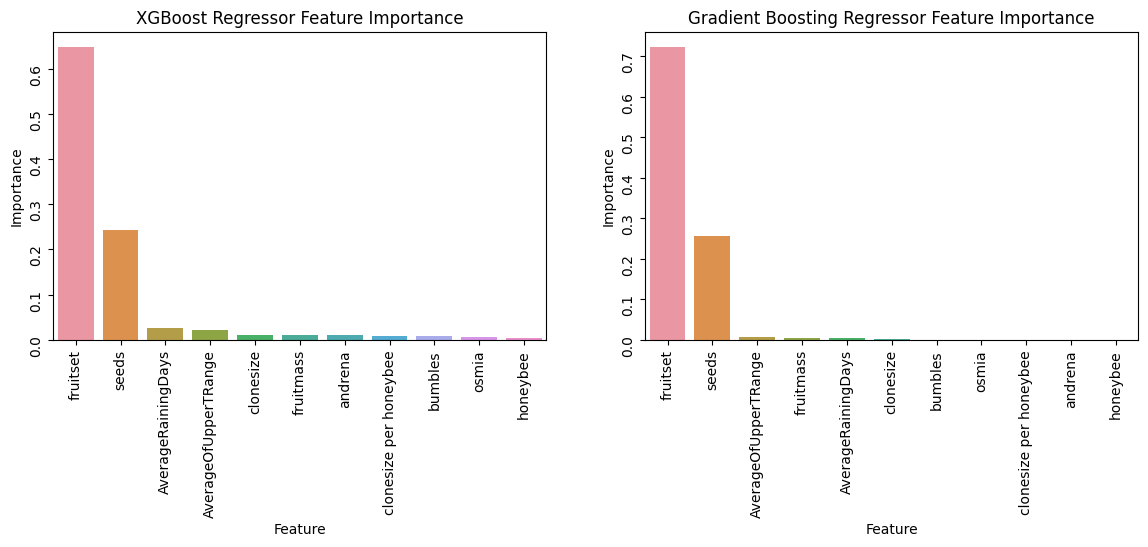

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

# Compute the feature importance
importances_xgb = sorted(list(zip(best_model_xgb.feature_names_in_,
                              best_model_xgb.feature_importances_)))

# Transform it into a DataFrame
importances_xgb_df = pd.DataFrame(importances_xgb,
                                     columns= ['Feature', 'Importance'])

# Sorting importances
importances_xgb_df = importances_xgb_df.sort_values(['Importance'], ascending=False).reset_index(drop=True)

# Plot the feature importance
ax[0] = sns.barplot(data=importances_xgb_df, 
                 x='Feature', 
                 y='Importance',
                 ax=ax[0])
ax[0].set_title('XGBoost Regressor Feature Importance')
ax[0].tick_params(labelrotation=90)

# Compute the feature importance
importances_gb = sorted(list(zip(best_model_gb.feature_names_in_,
                              best_model_gb.feature_importances_)))

# Transform it into a DataFrame
importances_gb_df = pd.DataFrame(importances_gb,
                                     columns= ['Feature', 'Importance'])

# Sorting importances
importances_gb_df = importances_gb_df.sort_values(['Importance'], ascending=False).reset_index(drop=True)

# Plot the feature importance
ax[1] = sns.barplot(data=importances_gb_df, 
                 x='Feature', 
                 y='Importance',
                 ax=ax[1])
ax[1].set_title('Gradient Boosting Regressor Feature Importance')
ax[1].tick_params(labelrotation=90)

plt.show()

## Learning curve

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16,4))

common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "cv": ShuffleSplit(n_splits=10, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Score",
}

for ax_idx, estimator in enumerate([model_xgb, best_model_gb]):
    
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    
    handles, label = ax[ax_idx].get_legend_handles_labels()
    
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")
    
plt.tight_layout()

## Residuals

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(14,4))

# Create a DataFrame of residuals for best_model_xgb
residuals_xgb = y_test - y_pred_best_xgb
df_resid_xgb = pd.DataFrame({'residuals': residuals_xgb, 'y_pred_best_xgb': y_pred_best_xgb})

# Plot the residuals for best_model_xgb
sns.residplot(x='y_pred_best_xgb',
              y='residuals', 
              data=df_resid_xgb, 
              ax=ax[0])
ax[0].set_title('XGBoost Regressor Residual Plot', fontsize=16)
ax[0].set_xlabel('Predicted values')
ax[0].set_ylabel('')

# Create a DataFrame of residuals for best_model_gb
residuals_bg = y_test - y_pred_best_gb
df_resid_bg = pd.DataFrame({'residuals': residuals_bg, 'y_pred_best_gb': y_pred_best_gb})

# Plot the residuals for best_model_gb
sns.residplot(x='y_pred_best_gb', 
              y='residuals', 
              data=df_resid_bg, 
              ax=ax[1])
ax[1].set_title('Gradient Boosting Regressor Residual Plot', fontsize=16)
ax[1].set_xlabel('Predicted values')
ax[1].set_ylabel('Residuals')

plt.show()

## Q-Q Plot

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

# Calculate the residuals for best_model_xgb
residuals_xgb = y_test - y_pred_best_xgb

# Generate a QQ plot for best_model_xgb
stats.probplot(residuals_xgb, 
               plot=ax[0])
ax[0].set_title('Q-Q Plot of XGBoost Regressor Residuals', fontsize=16)
ax[0].set_xlabel('Theoretical quantiles')
ax[0].set_ylabel('')

# Calculate the residuals for best_model_gb
residuals_gb = y_test - y_pred_best_gb

# Generate a QQ plot for model 1
stats.probplot(residuals_gb, 
               plot=ax[1])
ax[1].set_title('Q-Q Plot of Gradient Boosting Regressor Residuals', fontsize=16)
ax[1].set_xlabel('Theoretical quantiles')
ax[1].set_ylabel('Sample quantiles')

plt.show()

## Actual Values vs Predicted Values

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

# Plot the predicted vs actual values for each model
ax[0].scatter(y_test, 
            y_pred_best_gb, 
            label='GB - RMSE: {}'.format(rmse_best_gb))
ax[0].plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 
         'k--', 
         lw=2)

ax[1].scatter(y_test, 
            y_pred_best_xgb, 
            label='XGB - RMSE: {}'.format(rmse_best_xgb))
ax[1].plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 
         'k--', 
         lw=2)

# Add a legend to the plot
ax[0].legend()
ax[1].legend()

# Set x and y axis labels for the plot
ax[0].set_xlabel('Actual values')
ax[0].set_ylabel('Predicted values')
ax[1].set_xlabel('Actual values')
ax[1].set_ylabel('Predicted values')

fig.suptitle('Predicted vs Actual Values')

plt.show()

## Diagnostic considerations

from the various diagnostic plot we see that the models behave similarly.

- They both slightly overfit the trainig set (disproportion among features contribution and steeper learning curve for the training set against the test test)
- Both models are have quite poor performance in predicting extreme values (see Q-Q plots and Predicted vs Actual values plots)

This being said, tuned XGBoost looks to perform better, even if the RMSE is slighlt higher than the Gradient Boosting regressor model

# Challenge Submission

In [19]:
# Generate predictions with test set
submission_predictions = best_model_xgb.predict(df_test_scaled)

In [20]:
df_test_scaled.head()

,clonesize,honeybee,bumbles,andrena,osmia,AverageOfUpperTRange,AverageRainingDays,fruitset,fruitmass,seeds,clonesize per honeybee
0,0.802929,-0.385238,-0.613664,-1.638479,-2.454434,0.424487,0.401611,-1.389674,-1.038628,-1.183437,-0.259001
1,-1.092448,-0.385238,-0.613664,1.737386,0.269883,1.353617,-1.367767,-0.197520,-0.099560,0.169192,-0.636043
2,-1.092448,-0.385238,-0.613664,0.927179,0.269883,0.424487,-0.391558,1.084029,1.093698,0.960739,-0.636043
3,0.802929,0.306073,1.556078,-0.760754,0.269883,0.424487,-0.391558,-0.937347,-0.640116,-0.756362,0.495083
4,2.698305,0.997385,-0.613664,-1.638479,-2.454434,1.353617,0.401611,-1.905506,-1.557820,-1.639049,2.380292


In [21]:
# Create submission DataFrame
submission = pd.DataFrame({'id': df_test.id, 'yield': submission_predictions})

In [22]:
submission.head()

,id,yield
0,15289,4317.856639
1,15290,6076.414458
2,15291,7182.806359
3,15292,4777.592476
4,15293,3832.137882


In [23]:
# Write CSV File
submission.to_csv('./submission.csv', index=False)